In [1]:
print('What\'s up?') # In Python, \ scapes the following character.
                     # That's the reason it's not used in file paths

What's up?


# Notebook Imports

In [2]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [122]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by_id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/03_Testing/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

FONT_PATH = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Reading Files

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(stream))
print(type(message))
print(message)

<class '_io.TextIOWrapper'>
<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassa

In [5]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [6]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
        
stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [7]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [8]:
for i in generate_squares(5):
    print(i, end=' -> ')

0 -> 1 -> 4 -> 9 -> 16 -> 

## E-mail Body Extraction

In [9]:
def email_body_generator(path):
    
    for root, pathname, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [10]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00196.dd21040c7757d477c967ae71b537810e,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1
00056.c56d61cadd81b4ade0030c8dee384704,Note: \n\nThis is NOT SPAM!! This is NOT Unsol...,1
00219.eaf6c0ff67706c784f67f5c1225028a1,------=_NextPart_000_00D1_61B37D4A.A0476B56\n\...,1
00158.9c8bf53ed738031b4bfab819c4b3ef13,Wind up your mates today! Please visit http://...,1
00287.b0495a4dbdff36654c3b3ee2f92bdbf3,This is a multi-part message in MIME format.\n...,1


In [12]:
spam_emails.shape

(1898, 2)

In [13]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = spam_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

,MESSAGE,CATEGORY
00196.dd21040c7757d477c967ae71b537810e,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1
00056.c56d61cadd81b4ade0030c8dee384704,Note: \n\nThis is NOT SPAM!! This is NOT Unsol...,1
00219.eaf6c0ff67706c784f67f5c1225028a1,------=_NextPart_000_00D1_61B37D4A.A0476B56\n\...,1
00158.9c8bf53ed738031b4bfab819c4b3ef13,Wind up your mates today! Please visit http://...,1
00287.b0495a4dbdff36654c3b3ee2f92bdbf3,This is a multi-part message in MIME format.\n...,1


In [14]:
ham_emails.shape

(3298, 2)

In [15]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of the entire dataset is:', data.shape)
data.head()

Shape of the entire dataset is: (5196, 2)


,MESSAGE,CATEGORY
00196.dd21040c7757d477c967ae71b537810e,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1
00056.c56d61cadd81b4ade0030c8dee384704,Note: \n\nThis is NOT SPAM!! This is NOT Unsol...,1
00219.eaf6c0ff67706c784f67f5c1225028a1,------=_NextPart_000_00D1_61B37D4A.A0476B56\n\...,1
00158.9c8bf53ed738031b4bfab819c4b3ef13,Wind up your mates today! Please visit http://...,1
00287.b0495a4dbdff36654c3b3ee2f92bdbf3,This is a multi-part message in MIME format.\n...,1


In [16]:
data.tail()

,MESSAGE,CATEGORY
00846.a603afcbab0796cbe45d3be854562598,"On Tue, 23 Jul 2002, Jim Whitehead wrote:\n\n\...",0
00424.e39b1db8cf5575572abb4482fd3fced3,wintermute wrote:\n\n>>Anyone know where in Ir...,0
00374.957837ba252b473057711e3c4dbd1e26,"hey,\n\n\n\nAFAIK it isn't hard at all to crea...",0
01101.ff91c2c8fb18ed6e300ed2ac699f8ae4,"Evidently, I have permission to pass this alon...",0
01266.94f7e1cce0ec1935ca75d232e4dc684c,"On Mon, 19 Aug 2002 16:44:30 +0200, Matthias S...",0


# Data Cleaning: Checking for Missing Values

In [17]:
# Check if any messages bodies ar null
data.MESSAGE.isnull().values.any()

False

In [18]:
type("")

str

In [19]:
len("")

0

In [20]:
my_var = None

In [21]:
type(my_var)

NoneType

In [22]:
# Check if there are empty e-mails (sting length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [23]:
(data.MESSAGE.str.len() == 0).sum()

4

In [24]:
# Check the number of entries with Null/None values
data.MESSAGE.isnull().sum() + (data.MESSAGE.str.len() == 0).sum()

4

In [25]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds', 'cmds'], dtype='object')

# Remove System File Entries from Dataframe

In [26]:
data.drop(['cmds'], inplace=True)
data.shape

(5192, 2)

# Add Document IDs to track E-mails in Dataset

In [27]:
document_ids = range(len(data.index))
data['DOC_ID'] = document_ids

In [28]:
data.head()

,MESSAGE,CATEGORY,DOC_ID
00196.dd21040c7757d477c967ae71b537810e,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1,0
00056.c56d61cadd81b4ade0030c8dee384704,Note: \n\nThis is NOT SPAM!! This is NOT Unsol...,1,1
00219.eaf6c0ff67706c784f67f5c1225028a1,------=_NextPart_000_00D1_61B37D4A.A0476B56\n\...,1,2
00158.9c8bf53ed738031b4bfab819c4b3ef13,Wind up your mates today! Please visit http://...,1,3
00287.b0495a4dbdff36654c3b3ee2f92bdbf3,This is a multi-part message in MIME format.\n...,1,4


In [29]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1,00196.dd21040c7757d477c967ae71b537810e
1,Note: \n\nThis is NOT SPAM!! This is NOT Unsol...,1,00056.c56d61cadd81b4ade0030c8dee384704
2,------=_NextPart_000_00D1_61B37D4A.A0476B56\n\...,1,00219.eaf6c0ff67706c784f67f5c1225028a1
3,Wind up your mates today! Please visit http://...,1,00158.9c8bf53ed738031b4bfab819c4b3ef13
4,This is a multi-part message in MIME format.\n...,1,00287.b0495a4dbdff36654c3b3ee2f92bdbf3


In [30]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5187,"On Tue, 23 Jul 2002, Jim Whitehead wrote:\n\n\...",0,00846.a603afcbab0796cbe45d3be854562598
5188,wintermute wrote:\n\n>>Anyone know where in Ir...,0,00424.e39b1db8cf5575572abb4482fd3fced3
5189,"hey,\n\n\n\nAFAIK it isn't hard at all to crea...",0,00374.957837ba252b473057711e3c4dbd1e26
5190,"Evidently, I have permission to pass this alon...",0,01101.ff91c2c8fb18ed6e300ed2ac699f8ae4
5191,"On Mon, 19 Aug 2002 16:44:30 +0200, Matthias S...",0,01266.94f7e1cce0ec1935ca75d232e4dc684c


# Save to File using Pandas

In [31]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualized (Pie Chart)

In [32]:
data.CATEGORY.value_counts()

1    3792
0    1400
Name: CATEGORY, dtype: int64

In [33]:
ammount_of_spam = data.CATEGORY.value_counts()[0]
ammount_of_ham = data.CATEGORY.value_counts()[1]

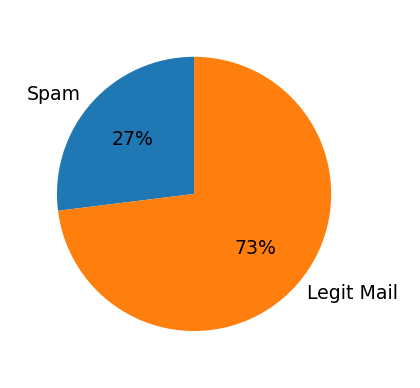

In [34]:
category_names = ['Spam', 'Legit Mail']
sizes = [ammount_of_spam, ammount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%')
plt.show()

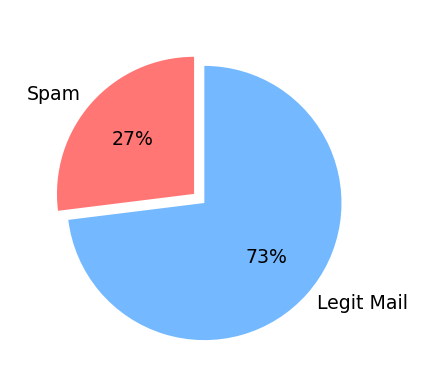

In [35]:
category_names = ['Spam', 'Legit Mail']
sizes = [ammount_of_spam, ammount_of_ham]
custom_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6},
        startangle=90, autopct='%1.0f%%', colors=custom_colors, explode=[0, 0.1])
plt.show()

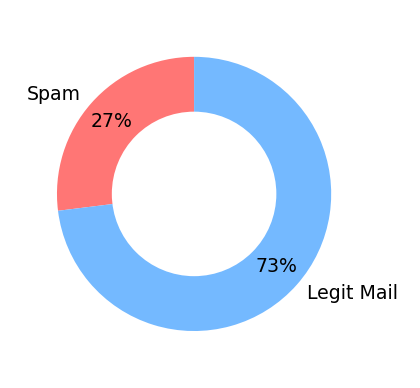

In [36]:
category_names = ['Spam', 'Legit Mail']
sizes = [ammount_of_spam, ammount_of_ham]
custom_colors = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6},
        startangle=90, autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8)

# Draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

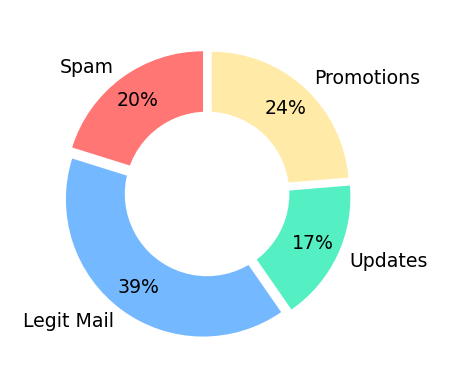

In [37]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [23, 45, 19, 27]
custom_colors = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05]*4

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6},
        startangle=90, autopct='%1.0f%%', colors=custom_colors,
        pctdistance=0.8, explode=offset)

# Draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

## Text Pre-Processing

In [38]:
# Covert to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

## Download the NLTK Resources (Tokenizer & Stopwords)

In [39]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [40]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guillermo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/guillermo/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     /home/guillermo/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

In [42]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words

In [43]:
stop_words = set(stopwords.words('english'))

In [44]:
if 'this' in stop_words: print('Found it!')

Found it!


In [45]:
if 'hello' not in stop_words: print('Nope. Not is here!')

Nope. Not is here!


In [46]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stems and Semming

In [47]:
msg = ('All work and no play makes Jack a dull boy. To be or not to be. ' + 
      'Nobody expects the Spanish Inquisition!')
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuation

In [48]:
'pap'.isalpha()

True

In [49]:
'?'.isalpha()

False

In [50]:
msg = ('All work and no play makes Jack a dull boy. To be or not to be.??? ' + 
      'Nobody expects the Spanish Inquisition!')
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removimg HTML Tags from E-mails

In [51]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

------=_NextPart_000_00D1_61B37D4A.A0476B56

Content-Type: text/html; charset="iso-8859-1"
<table border="0" cellpadding="0" cellspacing="0" width="725">
 <tbody>
  <tr>
   <td rowspan="2" style="FONT-SIZE: 8pt; FONT-FAMILY: Tahoma" valign="top" width="470">
    <table border="0" cellpadding="0" cellspacing="0" height="111" width="723">
     <tbody>
      <tr>
       <td colspan="4" height="111" style="FONT-SIZE: 8pt; FONT-FAMILY: Tahoma" valign="top" width="723">
        <b>
         <font color="#ff6600">
          Introduction
         </font>
        </b>
        <br/>
        We sell Backup 

CDs, also known as Warez CDs. Backup CDs are copies of Software.
        <p>
         For example if you go into a shop and buy Windows XP Pro, for about $299 you 

get the Serial, the CD, the Box and the Manual.
         <br/>
         <br/>
         If you order it off us, 

you get:
         <br/>
         The Windows XP CD and the Serial Number. It works exactly the same, 

but you don't 

In [52]:
soup.get_text()

'------=_NextPart_000_00D1_61B37D4A.A0476B56\n\nContent-Type: text/html; charset="iso-8859-1"\n\n\n\n\n\n\n\n\n\n\nIntroduction We sell Backup \n\nCDs, also known as Warez CDs. Backup CDs are copies of Software. \n\nFor example if you go into a shop and buy Windows XP Pro, for about $299 you \n\nget the Serial, the CD, the Box and the Manual.If you order it off us, \n\nyou get:The Windows XP CD and the Serial Number. It works exactly the same, \n\nbut you don\'t get the manual and box and the price is only $19.99.That is a \n\nsaving of $280, and the only difference is you don\'t have a colorful box and \n\nmanual - which are not very \n\nuseful.\nFeatures- over \n\n400 applications- over 1500 games- we reply at all your requests in a \n\nfew hours- newest releases - we have the best price on the WEB- best \n\nchoice of CD\'s ever seen on WEB- we ship orders to worldwide- secure \n\ncredit card processing thru our authorized on-line retailer. Your information \n\nwill be passed through

## Functions for e-mail processing

In [53]:
def clean_message(message, stemmer=PorterStemmer(),
                           stop_words=set(stopwords.words('english'))):
    
    # Converts to lowercase and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [54]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [55]:
def clean_msg_no_html(message, stemmer=PorterStemmer(),
                      stop_words=set(stopwords.words('english'))):
    
    # Remove HTML Tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to lowercase and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [56]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['introduct',
 'sell',
 'backup',
 'cd',
 'also',
 'known',
 'warez',
 'cd',
 'backup',
 'cd',
 'copi',
 'softwar',
 'exampl',
 'go',
 'shop',
 'buy',
 'window',
 'xp',
 'pro',
 'get',
 'serial',
 'cd',
 'box',
 'order',
 'us',
 'get',
 'window',
 'xp',
 'cd',
 'serial',
 'number',
 'work',
 'exactli',
 'get',
 'manual',
 'box',
 'price',
 'save',
 'differ',
 'color',
 'box',
 'manual',
 'use',
 'repli',
 'request',
 'newest',
 'releas',
 'best',
 'price',
 'best',
 'choic',
 'cd',
 'ever',
 'seen',
 'ship',
 'order',
 'secur',
 'credit',
 'card',
 'process',
 'thru',
 'author',
 'retail',
 'inform',
 'pass',
 'secur',
 'server',
 'encrypt',
 'need',
 'worri',
 'someon',
 'steal',
 'credit',
 'card',
 'detail',
 'popular',
 'cd',
 'adob',
 'photoshop',
 'finallonli',
 'ms',
 'window',
 'xp',
 'ms',
 'offic',
 'xp',
 'pro',
 'gratitud',
 'custom',
 'john',
 'stewartthank',
 'guy',
 'got',
 'set',
 'cd',
 'work',
 'promis',
 'got',
 'happi',
 'custom',
 'readi',
 'order',
 'send',
 'cust

# Apply Cleaning and Toquenisation to all messages

## Slicing Dataframes and Series & Crating Subsets

In [57]:
data.iat[2, 0]

'------=_NextPart_000_00D1_61B37D4A.A0476B56\n\nContent-Type: text/html; charset="iso-8859-1"\n\n\n\n<TABLE cellSpacing=0 cellPadding=0 width=725 border=0>\n\n<TBODY>\n\n<TR>\n\n<TD style="FONT-SIZE: 8pt; FONT-FAMILY: Tahoma" vAlign=top width=470 rowSpan=2>\n\n<TABLE height=111 cellSpacing=0 cellPadding=0 width=723 border=0>\n\n<TBODY>\n\n<TR>\n\n<TD style="FONT-SIZE: 8pt; FONT-FAMILY: Tahoma" vAlign=top width=723 colSpan=4 \n\nheight=111><B><FONT color=#ff6600>Introduction</FONT></B> <BR>We sell Backup \n\nCDs, also known as Warez CDs. Backup CDs are copies of Software. \n\n<P>For example if you go into a shop and buy Windows XP Pro, for about $299 you \n\nget the Serial, the CD, the Box and the Manual.<BR><BR>If you order it off us, \n\nyou get:<BR>The Windows XP CD and the Serial Number. It works exactly the same, \n\nbut you don\'t get the manual and box and the price is only $19.99.<BR>That is a \n\nsaving of $280, and the only difference is you don\'t have a colorful box and \n\n

In [58]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
6,------000000000000000000000\n\nContent-Type: t...,1,00335.f71c6e9b23487811a44e6aeaa50e73a5
7,"\n\nÐÏà¡±á Worldwide*\n\nGreat Restaurants, ...",1,00136.faa39d8e816c70f23b4bb8758d8a74f0
8,<html>\n\n<head>\n\n<title>Digital Publishing ...,1,00357.b523d4209d633d6fdf86b93bc19e3aa2
9,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E...",1,00297.3350c2dbbb0272c27b2c7773d7012356
10,\n\n<HTML><TABLE WIDTH=100% BORDER=0 CELLPADDI...,1,00304.ed5fbfc3e6f2be662f29f43f172a1fb3


In [59]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [60]:
# flat_list = []

# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)
        
flat_list = [item for sublist in nested_list for item in sublist]
len(flat_list)

840

In [61]:
%%time

# Use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

CPU times: user 1min 15s, sys: 0 ns, total: 1min 15s
Wall time: 1min 15s


In [62]:
nested_list.head()

DOC_ID
0    [norton, ad, take, control, comput, softwar, n...
1    [note, spam, unsolicit, email, receiv, messag,...
2    [introduct, sell, backup, cd, also, known, war...
3              [wind, mate, today, pleas, visit, http]
4    [messag, mime, format, look, properti, spain, ...
Name: MESSAGE, dtype: object

In [63]:
nested_list.tail()

DOC_ID
5187    [tue, jul, jim, whitehead, wrote, download, pa...
5188    [wintermut, wrote, anyon, know, ireland, get, ...
5189    [hey, afaik, hard, creat, modifi, version, red...
5190    [evid, permiss, pass, along, tri, home, boy, g...
5191    [mon, aug, matthia, saou, wrote, snip, bother,...
Name: MESSAGE, dtype: object

## Using Logic to Slice Dataframes

In [64]:
data[data.CATEGORY == 1].shape

(3792, 3)

In [65]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [66]:
doc_ids_spam

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791],
           dtype='int64', name='DOC_ID', length=3792)

In [67]:
doc_ids_ham

Int64Index([3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801,
            ...
            5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5191],
           dtype='int64', name='DOC_ID', length=1400)

## Subsetting a Series with an Index

In [68]:
nested_list_ham = nested_list[doc_ids_ham]

In [69]:
nested_list_spam = nested_list[doc_ids_spam]

In [70]:
# Use Python list comprehension and find the total number of words in
# our cleaned data of spam e-mail bodies.
# Find the 10 most common words.
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words[:10]

http      6194
email     6180
free      5170
click     4116
receiv    3978
list      3942
get       3828
pleas     3704
busi      3584
order     3492
dtype: int64

In [71]:
# Use Python list comprehension and find the total number of words in
# our cleaned data of non spam e-mail bodies.
# Find the 10 most common words.
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words[:10]

http     3251
use      1509
list     1494
one      1035
mail     1017
user      952
linux     915
get       905
would     861
file      808
dtype: int64

## Creating a Word Clud

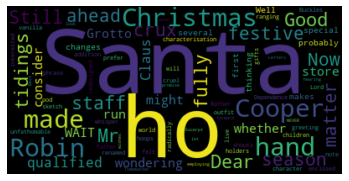

In [72]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [73]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [74]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [75]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [76]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

In [77]:
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

In [78]:
# %%time

# icon = Image.open(WHALE_FILE)
# image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
# image_mask.paste(icon, box=icon)

# rgb_array = np.array(image_mask) # Coverts the image object to an array

# word_cloud = WordCloud(mask=rgb_array, background_color='white',
#                        max_words=400, colormap='ocean')
# word_cloud.generate(novel_as_string)

# plt.figure(figsize=[16, 8])
# plt.imshow(word_cloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [79]:
# %%time

# hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
# hamlet_word_list = [''.join(word) for word in hamlet_corpus]
# hamlet_as_string = ' '.join(hamlet_word_list)

# icon = Image.open(SKULL_FILE)
# image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
# image_mask.paste(icon, box=icon)

# rgb_array = np.array(image_mask) # Coverts the image object to an array

# word_cloud = WordCloud(mask=rgb_array, background_color='white',
#                        max_words=600, colormap='bone')
# word_cloud.generate(hamlet_as_string)

# plt.figure(figsize=[10, 10])
# plt.imshow(word_cloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

# Wordcloud for Ham & Spam Messages

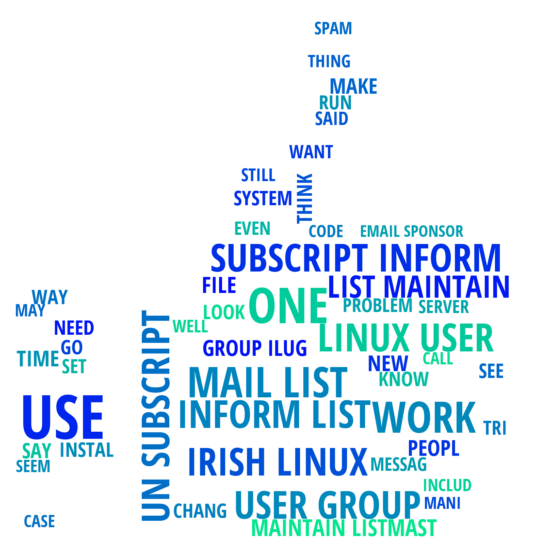

In [80]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # Coverts the image object to an array

# Generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(font_path=FONT_PATH, mask=rgb_array, background_color='white',
                       max_words=50, colormap='winter')
word_cloud.generate(ham_str.upper())

plt.figure(figsize=[10, 10])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

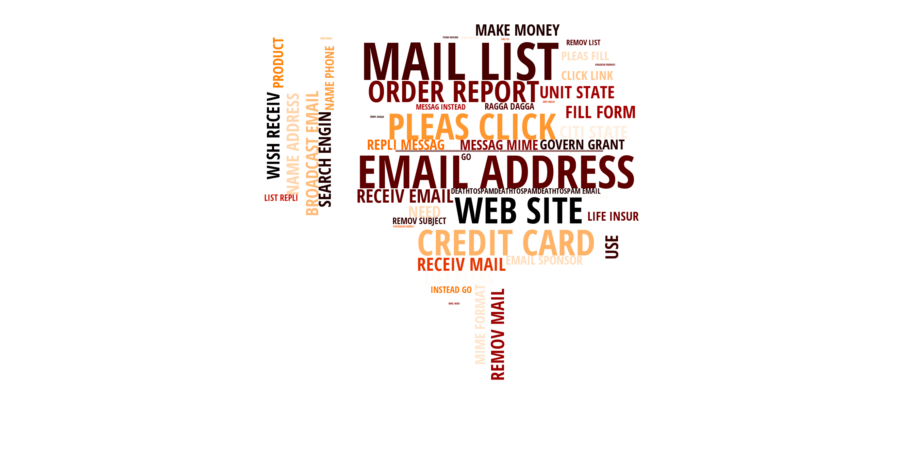

In [81]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # Coverts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(font_path=FONT_PATH, mask=rgb_array, background_color='white',
                       max_words=50, colormap='gist_heat')
word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 16])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [82]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [83]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr. of unique words', unique_words.shape[0])
unique_words.head()

Nr. of unique words 20514


http     9445
email    6769
list     5436
free     5340
get      4733
dtype: int64

In [84]:
# Subset of the series called 'frequent_words' that onñly contains
# the most common 2500 words out of the total. Print out the top 10 words.
frequent_words = unique_words[:VOCAB_SIZE]
print('Most frequent words:\n', frequent_words[:10])

Most frequent words:
 http      9445
email     6769
list      5436
free      5340
get       4733
mail      4473
use       4281
receiv    4166
click     4146
one       4103
dtype: int64


## Craeate Vocabulary DataFrame with a WORD_ID

In [85]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,email
2,list
3,free
4,get


## Save the Vocabulary as a CSV File

In [86]:
vocab.to_csv(WORD_ID_FILE, index=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Checking if a word is part of a Vocabulary

In [87]:
# Write a line of code that checks if a particular word is part
# of the vocabulary. Your code should return True if the word is among the
# 2500 words that comprise the vocabulary, and False otherwise. Checke the words:
# 'machine'
# 'learn'
# 'fun'
# 'data'
# 'science'
# 'app'
# 'brewery'

'brewery' in vocab.VOCAB_WORD.to_list()

False

In [88]:
any(vocab.VOCAB_WORD == 'machine') # inefficient

False

In [89]:
'learn' in set(vocab.VOCAB_WORD) # better way

True

## Find the email with the most number of words

In [90]:
# Print out the number of words in teh longuest e-mail (after cleaning & stemming).
# Note the longuest e-mail position in the list of cleaned e-mails. Print out the stemmed
# list of words in the longest e-mail. Print out the longuest e-mail from the data dataframe.

clean_email_lenghts = [len(sublist) for sublist in stemmed_nested_list]
print('Number of words in the longuest e-mail (after cleaning & stemming):', max(clean_email_lenghts))

Number of words in the longuest e-mail (after cleaning & stemming): 7671


In [91]:
# print('E-mail position in the list (and the dataframe):', clean_email_lenghts.index(max(clean_email_lenghts)))
print('E-mail position in the list (and the dataframe):', np.argmax(clean_email_lenghts))

E-mail position in the list (and the dataframe): 4591


In [92]:
nested_list[np.argmax(clean_email_lenghts)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [93]:
data.at[np.argmax(clean_email_lenghts), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

## Creating a DataFrame with one Word per Column

In [94]:
type(stemmed_nested_list)

pandas.core.series.Series

In [95]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,norton,ad,take,control,comput,softwar,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
1,note,spam,unsolicit,email,receiv,messag,receiv,certain,special,offer,...,None,None,None,None,None,None,None,None,None,None
2,introduct,sell,backup,cd,also,known,warez,cd,backup,cd,...,None,None,None,None,None,None,None,None,None,None
3,wind,mate,today,pleas,visit,http,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,messag,mime,format,look,properti,spain,wast,time,peopl,look,...,None,None,None,None,None,None,None,None,None,None


In [96]:
word_columns_df.shape

(5192, 7671)

## Spliting the Data into a Training and Testing Dataset

In [97]:
# Split the data into a training and testing set. Set the test size al 30%.
# The training data should include 4057 e-mails. Use a seed value of 42 to shuffle the data.
# What should the target values be?

X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                    test_size=0.3, random_state=42)

In [98]:
print('Nr. of training samples:', X_train.shape[0])
print('Fraction of training set:', X_train.shape[0]/data.shape[0])

Nr. of training samples: 3634
Fraction of training set: 0.6999229583975347


In [99]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4970,tom,wrote,mon,jul,adam,rifkin,wrote,john,markoff,ahhh,...,None,None,None,None,None,None,None,None,None,None
1482,receiv,mail,member,subscrib,jm,unsubscrib,click,http,repli,email,...,None,None,None,None,None,None,None,None,None,None
1189,messag,mime,format,annuiti,guru,versu,commission,mortal,combat,month,...,None,None,None,None,None,None,None,None,None,None
328,help,want,year,old,fortun,compani,grow,tremend,rate,look,...,None,None,None,None,None,None,None,None,None,None
648,fax,direct,confidenti,fax,kataga,bakori,lago,nigeria,juli,attent,...,None,None,None,None,None,None,None,None,None,None


In [100]:
y_train.head()

DOC_ID
4970    0
1482    1
1189    1
328     1
648     1
Name: CATEGORY, dtype: int64

## Create a Sparse Matrix for the training data

In [101]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [105]:
word_index.get_loc('thu')

641

In [111]:
def make_sparse_matrix(df, indexed_words, labels):
    """Returns a sparse matrix as dataframe.
    
    df -- A dataframe with words in the columns with a document id as an index (X-train or X_test)
    word_index -- index of words ordered by word_id
    labels -- category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {
                    'LABEL': category,
                    'DOC_ID': doc_id,
                    'OCCURENCE': 1,
                    'WORD_ID': word_id
                       }
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [112]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 1h 1min 34s, sys: 11.7 s, total: 1h 1min 45s
Wall time: 1h 5min 59s


## Combine Occurences with the Pandas groupby() method

In [114]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      1       1              3
       2       1              3
       3       1              2
       4       1              1
       6       1              1

In [116]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,1,1,3
1,0,2,1,3
2,0,3,1,2
3,0,4,1,1
4,0,6,1,1


In [117]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
267795,5189,2227,0,1
267796,5189,2252,0,2
267797,5189,2324,0,6
267798,5189,2356,0,1
267799,5189,2431,0,1


In [119]:
vocab.at[2252, 'VOCAB_WORD']

'complic'

In [120]:
sparse_train_df.shape

(480895, 4)

In [121]:
train_grouped.shape

(267800, 4)

## Saving Training data as .txt File

In [123]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [124]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

# Challenge

Create a sparse matrix for the test data. Group the occurences of the same words in the same e-mail. Then save the data as a .txt file.